In [10]:
import numpy as np
import pandas as pd
import matplotlib as plt 

First we define the function that we are going to use for our analysis:

Penman-Monteith equation

$
\lambda E T_o=\frac{\Delta\left(R_n-G\right)+\frac{86,400 \rho_a C_P\left(e_s^o-e_a\right)}{r_{a v}}}{\Delta+\gamma\left(1+\frac{r_s}{r_{a v}}\right)}
$

In [11]:
def PenmanMonteith(e0, ea, dedT, R_net, G, z, Uz, hc, r_s):
    
    gamma = 0.066 #psychrometric constant [kPa °C -1] (at sea level  101.325 kPa!)
    rho_air = 1.2250 #density of air at seal level ( 101.325 kPa) and 15°C [kg/m³]
    capacity_air = 1.013e-3 #heat capacity of air [MJ kg -1 °C -1]
        
    r_av = WaterVapourAerodynamicResistance(z, Uz, hc)
    
    LET1 = dedT * (R_net - G) + (86400 * rho_air * capacity_air * (e0 - ea)) / r_av
    LET = LET1 / (dedT + gamma * (1. + r_s/r_av) )
    
    return LET

The statuaration vapour pressure [Pa] can be approximated using the August-Roche-Magnus equation

${ e_{sat}(T) = 610.94 e^{\frac{17.625 T}{T+243.04}} }$

In [12]:
def SaturationVapourPressure(T):
    #saturation vapour pressure [Pa] - August-Roche-Magnus equation
    e_sat = 100 * 6.1094 * np.exp(17.625*T/(T+243.04))
    return e_sat #[Pa]

The derivative is than

$\Delta = \frac{\partial e_{sat}(T)}{\partial T} = \frac{2617010}{T+243.04} e^{\frac{17.625 T}{T+243.04}} $

In [13]:
def SaturationVapourPressureDerivative(T):
    #derivative of the saturation vapour pressure [Pa/K] - August-Roche-Magnus equation
    de_sat_dT = 2.61701e6 * np.exp(17.625*T/(T+243.04)) * (T+243.04)**(-2)
    return de_sat_dT #[Pa/K]

We also need to approximate some aerodynamic parameters that control the turbulent exchange between the land surface and the atmosphere. These include the surface roughness (expressed as roughness length $z_0$ [m]) and the displacement height $d$, which marks the height [m] at which the turbulent exchange becomes effective. 

Estimating displacement height and roughness length based on vegetation height $h_c$

$
\begin{aligned}
& d = (2 / 3) h_c \\
& z_{\text {om }} = 0.123 h_c \\
& z_{\text {ov }} = 0.1 z_{\text {om }}
\end{aligned}
$

With these parameters and the assumption of a logarithmic wind profile, we can calculate the aerodynamic exchange coefficient - here expressed as resistance.

$
r_{a v}=\frac{\ln \left[\frac{\left(z_w-d\right)}{z_{o m}}\right] \ln \left[\frac{\left(z_r-d\right)}{z_{o v}}\right]}{k^2 U_z}
$



In [14]:
def WaterVapourAerodynamicResistance(z,Uz,hc):
    z_w = z #wind speed measurement hight [m]
    k = 0.41 #von Karman constant [-]
    
    d = 2./3. * hc #displacment hight estmated based on vegetation hight [m]
    z_0m = 0.123 * hc #roughness length momentum [m]
    z_0v = 0.1 * z_0m #roughness length surface [m]
    
    r_av = np.log((z_w-d)/z_0m) * np.log((z_w-d)/z_0v) * (k**2 * Uz)**(-1) 
    
    return r_av

In [15]:
#load meteorological observations
file = 'data/Samoylov_2002-2011_meteorology.tab'
dataset = pd.read_csv(file,delimiter="\t")
dataset['DateTime'] = pd.to_datetime(dataset['Date/Time'])
dataset = dataset.drop(columns=['Date/Time'])

dataset = dataset.set_index(['DateTime'])
dataset = dataset.loc['2011-1-1':'2011-8-25'] 

df_mean = dataset.groupby(by=pd.Grouper(freq='D')).mean()
df_min = dataset.groupby(by=pd.Grouper(freq='D')).min()
df_max = dataset.groupby(by=pd.Grouper(freq='D')).max()
 
meteorology_mean = df_mean   
meteorology_min = df_min   
meteorology_max = df_max   

#load wind speed measurments
file = 'data/Samoylov_2002-2011_wind_speed.tab'
#this is just a test
dataset = pd.read_csv(file,delimiter="\t")
dataset['DateTime'] = pd.to_datetime(dataset['Date/Time'])
dataset = dataset.drop(columns=['Date/Time'])


dataset = dataset.set_index(['DateTime'])
dataset = dataset.loc['2011-1-1':'2011-8-25'] 

windspeed_mean = dataset.groupby(by=pd.Grouper(freq='D')).mean()

In [16]:
print(meteorology_mean.keys())
print(windspeed_mean.keys())

Index(['Height [m]', 'T2 [°C]', 'RH [%]', 'NET [W/m**2]', 'Precip [mm/h]'], dtype='object')
Index(['Height [m]', 'ff [m/s]'], dtype='object')


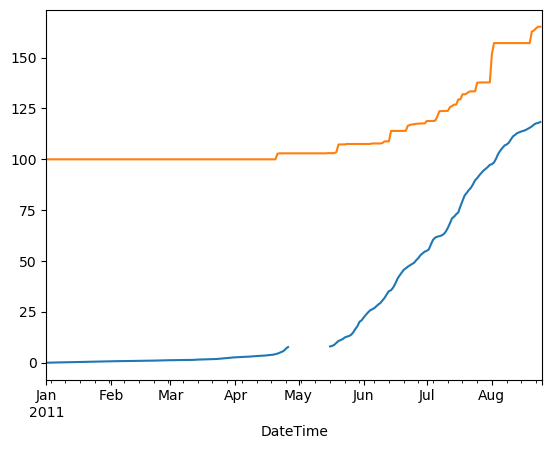

In [17]:
#variables
Uz_av = windspeed_mean['ff [m/s]']
Rnet = np.array([0,200,600])#[W/m²s]

#Note net radiation and groud heat flux must be proved as [MJ m^2 / day] 
dt = 86400
Rnet_av = meteorology_mean['NET [W/m**2]']
Rnet_av = Rnet_av * dt / 1e6

G_av = Rnet_av*0.02 
T_av = meteorology_mean['T2 [°C]'] 
RH_av = meteorology_mean['RH [%]'] / 100.
ea = RH_av * SaturationVapourPressure(T_av)/1000.
dedT = SaturationVapourPressureDerivative(T_av)/1000.
T_min = meteorology_min['T2 [°C]']
T_max = meteorology_max['T2 [°C]']
e0 = 0.5 * (SaturationVapourPressure(T_min) + SaturationVapourPressure(T_max))/1000.

#input parameter for Penman Monteith equation    
z = 3.0 #[m] wind speed mesurmeent hight above ground
hc = 0.10 #[m] crop (vegetation) hight above ground
rs = 250 #[-] surface resitance to evapotranspiration

#apply the Penman Monteith equation 
LET = PenmanMonteith(e0, ea, dedT, Rnet_av, G_av, z, Uz_av, hc, rs) #[MJ/m²day]
#transfrom from [MJ/day] to [mm]
L = 2.45 #[MJ kg -1]
ET = LET/L #[mm/day]

#Note that percipitation was measured as mm/h which must be intergrated over 24h 
P = meteorology_mean['Precip [mm/h]']*24.
S_snow = 100. #[mm] end of season snow water equivalent see/change according to e.g. Boike et al. (2013)

# here we plot the cumulative sum pf  
ET.cumsum().plot() #evapotranspiration [mm]
(P.cumsum() + S_snow).plot() #percipitation [mm]


Now we have P and ET for the a polygonal center. So we can rename the calculated variables

In [12]:
ET_c = ET
P_c = P

To complete our water balance the flux from the rim Q_r is still missing which we approximate as

$\huge{ Q_r \approx 0.5 f_r (P_r - ET_r) }$

$P_r$ is the same as $P_c$ so only $ET_r$ must be calculated similar to $ET_c$ but with adjusted paramters

In [21]:
#add here your calaculations to optaind Q_r



In the next step we can put the complete water budget for the polygon center together following

$\huge{ \Delta S_c = P_c - ET_c + Q_r }$


In [19]:
#add here your calculations to optain the water budget changes



Now lets approximate the water table in the polygon center which is calaculated by summing up all daily water budget changes and add the initial water for the snow cover.

$\huge{ WT_c = S_{snow} + \sum {\Delta S_c} }$





In [20]:
#add here your calculations to optain the water level 



The evolution of the water table of the polygon center can be compared to the evolution thaw depth in the polygon rim. Please note that the polygon rim is typicall 0.5m elevated.
You find all function required to calculate the thaw and an example how to use it in the Notebook "ThawDepth.ipynb"

In [ ]:
#add here your the thaw depth functions and your calculations of the polygon rim thaw depth relatice to the polygon center water table



Now its time to make a nice plot

In [ ]:
#add here your ploting script


